#Paris Trading
This Jupyter Notebook demonstrates the implementation of a Pairs Trading Strategy. Traditional methods for identifying pairs, such as simple strategies based on historical price correlations, have been widely used. However, these methods often lead to diminishing profit margins in competitive markets, making **the selection of pairs a critical determinant of a strategy's success**.

---

In this project, I enhance the pair selection process by incorporating methods inspired by the paper "Enhancing a Pairs Trading Strategy with the Application of Machine Learning" (published in Expert Systems with Applications, a top-tier JCR Q1 journal). By combining **unsupervised machine learning algorithms** and **statistical analysis**, the strategy improves pair selection effectiveness and overcomes the limitations of traditional approaches (e.g., restricting pairs to the same industry). This enhanced methodology offers greater profit potential in highly competitive environments.


##Notebook Structure
This notebook is divided into two main modules:
1. Identifying and Selecting Pairs
2. Backtesting the Pairs Trading Strategy


Key Steps in Pair Selection:
1. **Dimensionality Reduction with PCA:** Reduces noise in stock price data.
2. **Clustering with OPTICS:** OPTICS is particularly advantageous as it does not require specifying the number of clusters, works across industries, handles outliers effectively, and supports clusters of arbitrary shapes.
3. **Statistical and Stability Tests:** Filters suitable pairs using stationarity tests, Hurst exponent, cointegration tests, and controls for half-life.

The detailed implementation is provided in the following sections.




In [ ]:
pip install vectorbt

In [ ]:
pip install -U kaleido

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import sys
#import pandas_ta as ta

In [2]:
import vectorbt as vbt

##Data Loading and Cleaning
This section focuses on selecting and preparing the stock data for analysis. The dataset includes stocks from the **S&P 500** and **Nasdaq 100** indices, covering the time period **from January 1, 2021, to November 1, 2024** with **1day** interval data.

###Why Choose S&P 500 and Nasdaq 100?

1. Diverse Industry Representation:
* The S&P 500 encompasses companies from traditional industries such as manufacturing and energy.
* The Nasdaq 100 is heavily concentrated in technology stocks.
* This diversity provides opportunities for hedging. For example, during the early stages of the COVID-19 pandemic, global supply chain disruptions severely affected traditional industries, while technology stocks were relatively less impacted. By identifying pairs across these indices, the strategy can build more resilient portfolios.
2. Liquidity Assurance:
* Stocks in these indices typically exhibit high liquidity, reducing the risk of market impact or slippage during trades.
* High liquidity ensures smoother execution, which is crucial for short-term strategies such as pairs trading.

In [3]:
#Using S&P 500 and Nasdaq 100, a total of 600 stocks
url_sp500='https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
url_ns100='https://en.wikipedia.org/wiki/Nasdaq-100'
sp500=pd.read_html(url_sp500)[0]
ns100=pd.read_html(url_ns100)[4]

In [4]:
#Data cleaning to obtain tickers
ticker=pd.concat([(sp500[['Symbol','GICS Sector']].rename(columns={'Symbol':'Ticker'})),ns100[['Symbol','GICS Sector']].rename(columns={'Symbol':'Ticker'})])
ticker=ticker.reset_index(drop=True)

In [5]:
#Remove duplicates
ticker=ticker.drop_duplicates(subset=['Ticker']).reset_index(drop=True)

In [6]:
#classified by industry
ticker['GICS Sector'].value_counts()

GICS Sector
Information Technology    79
Industrials               78
Financials                72
Health Care               63
Consumer Discretionary    53
Consumer Staples          39
Utilities                 31
Real Estate               31
Materials                 28
Communication Services    23
Energy                    22
Name: count, dtype: int64

In [7]:
print(ticker['Ticker'].nunique())
print(ticker.shape)

519
(519, 2)


In [8]:
#Load data
ticker_input=list(ticker['Ticker'])
#Load daily 15-minute closing price data
#data_raw=yf.download(ticker_input,start='2018-01-01',end='2024-10-01',interval='1d').get('Adj Close')
data_raw=yf.download(ticker_input,start='2021-01-01',end='2024-11-01',interval='1d').get('Adj Close')

[*********************100%***********************]  519 of 519 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2021-01-01 -> 2024-11-01)')


In [9]:
#(Skipped) Volume filtering to ensure that each stock is traded every day; all stocks meet the criteria (Skipped)
#data=yf.download(ticker_input,period='1y',interval='1d').get('Volume')

In [9]:
#Filter missing values
miss=data_raw.isnull().sum()
miss_list=miss[miss>0].index.tolist()
data_raw.drop(columns=miss_list,inplace=True)

In [10]:
data_raw.shape

(964, 506)

##Pair Selection
This section outlines the main steps for identifying potential trading pairs:
* **Standardizing Returns**
* **Dimensionality Reduction with PCA**
  * Several attempts were made to determine the optimal number of principal components. Including too many components risks overfitting and the "curse of dimensionality," leading to increased computational costs and the inclusion of noise.
* **Clustering with OPTICS**
* **Visualizing Clustering Results**


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
#Split dataset
df_prices_train,df_prices_test=train_test_split(data_raw,test_size=0.1,random_state=44,shuffle=False)

In [13]:
#Calculate daily returns
data=df_prices_train.pct_change().dropna()

In [14]:
print('The total number of potential combinations is:',len(data.columns)*(len(data.columns)-1)/2)

The total number of potential combinations is: 127765.0


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
#Standardize returns
norm=StandardScaler()
norm_data=norm.fit_transform(data)

In [17]:
#PCA dimensionality reduction
def apply_PCA(components,df,svd_solver='auto',random_state=44):
  if not isinstance(components,str):
    if components>df.shape[0]:
      print('ERROR: Number of principal components exceeds the number of samples')
      exit()
  pca=PCA(n_components=components,svd_solver=svd_solver,random_state=random_state)
  pca.fit(norm_data)
  explained_variance=pca.explained_variance_
  return pca.components_.T,explained_variance

In [18]:
#comp=5
X,explained_variance=apply_PCA(5,norm_data)

In [19]:
X.shape

(506, 5)

In [20]:
explained_variance

array([164.62127366,  31.41078965,  26.16008032,  10.48649555,
        10.1611409 ])

In [21]:
from sklearn.cluster import OPTICS

In [22]:
#OPTICS clustering
def apply_OPTICS(x,df,min_samples,max_eps=2,xi=0.05,cluster_method='xi'):
  clf=OPTICS(min_samples=min_samples,max_eps=max_eps,xi=xi,metric='euclidean',cluster_method=cluster_method)
  print(clf)
  clf.fit(X)
  labels=clf.labels_
  n_clusters_=len(set(labels))-(1 if -1 in labels else 0)
  print(f'clusters discovered:{n_clusters_}')
  clustered_series_all=pd.Series(index=df.columns,data=labels.flatten())
  clustered_series=clustered_series_all[clustered_series_all!=-1]
  counts=clustered_series.value_counts()
  print(f'Pairs to evaluate:{(counts*(counts-1)/2).sum()}')
  return clustered_series_all,clustered_series,counts,clf

In [23]:
#Clustering results
clustered_series_all,clustered_series,counts,clf=apply_OPTICS(X,data,6)

OPTICS(max_eps=2, metric='euclidean', min_samples=6)
clusters discovered:14
Pairs to evaluate:787.0


###Visualizing Clustering Results
The clustering results are visualized through the following figures:
* Figure 1: Displays the number of stocks in each cluster.
* Figure 2: A t-SNE plot illustrating the clustering results. Each color represents a distinct cluster, and each dot corresponds to a stock. Gray dots indicate stocks that were not selected for any cluster.
* Figure 3: Shows the stock price trends for each cluster. Stocks within the same cluster exhibit similar price movements, validating the clustering results.

In [24]:
#Visualize stocks in each cluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def plot_cluster_size(counts):
  plt.figure(figsize=(8,6))
  plt.barh(counts.index+1,counts.values)
  plt.yticks(np.arange(1,len(counts)+1,1))
  plt.xlabel('tickers within cluster',size=12)
  plt.ylabel('Cluster ID',size=12)

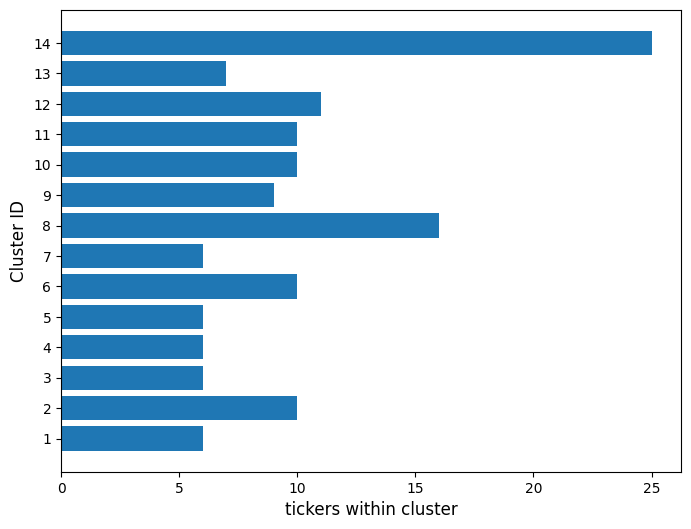

In [25]:
plot_cluster_size(counts)

In [26]:
#Visualize clustering results using t-SNE
from sklearn.manifold import TSNE
def plot_t_SNE(X,clf,clustered_series_all):
  X_tsne=TSNE(learning_rate=1000,perplexity=25,random_state=44).fit_transform(X)
  fig=plt.figure(1,facecolor='white',figsize=(10,10),frameon=True,edgecolor='black')
  plt.clf()

  ax=fig.add_subplot(1,1,1,alpha=0.9)
  ax.spines['left'].set_position('center')
  ax.spines['left'].set_alpha(0.3)
  ax.spines['bottom'].set_position('center')
  ax.spines['bottom'].set_alpha(0.3)
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')

  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  ax.tick_params(which='major',labelsize=8)

  labels=clf.labels_
  x=X_tsne[(labels!=-1),0]
  y=X_tsne[(labels!=-1),1]
  tickers=list(clustered_series_all[clustered_series_all!=-1].index)
  plt.scatter(x,y,s=300,alpha=0.75,c=labels[labels!=-1],cmap=cm.Paired)
  for i,ticker in enumerate(tickers):
    plt.annotate(ticker,(x[i]-2,y[i]+1),size=8)
  x=X_tsne[(clustered_series_all==-1).values,0]
  y=X_tsne[(clustered_series_all==-1).values,-1]
  tickers=list(clustered_series_all[clustered_series_all==-1].index)

  plt.scatter(x,y,s=150,alpha=0.2,c='black')
  #plt.xlabel('t-SNE Dim. 1',position=(0.92,0),size=10)
  #plt.ylabel('t-SNE Dim. 2',position=(0,0.92),size=10)
  #ax.set_xticks(range(-300,301,600))
  #ax.set_yticks(range(-300,301,600))
  plt.show()



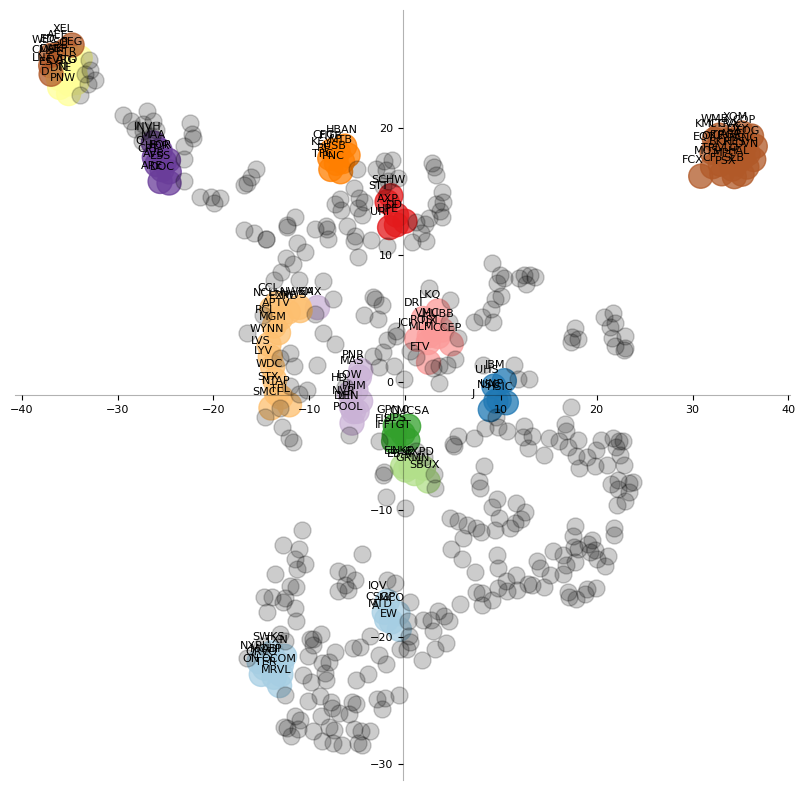

In [27]:
plot_t_SNE(X,clf,clustered_series_all)

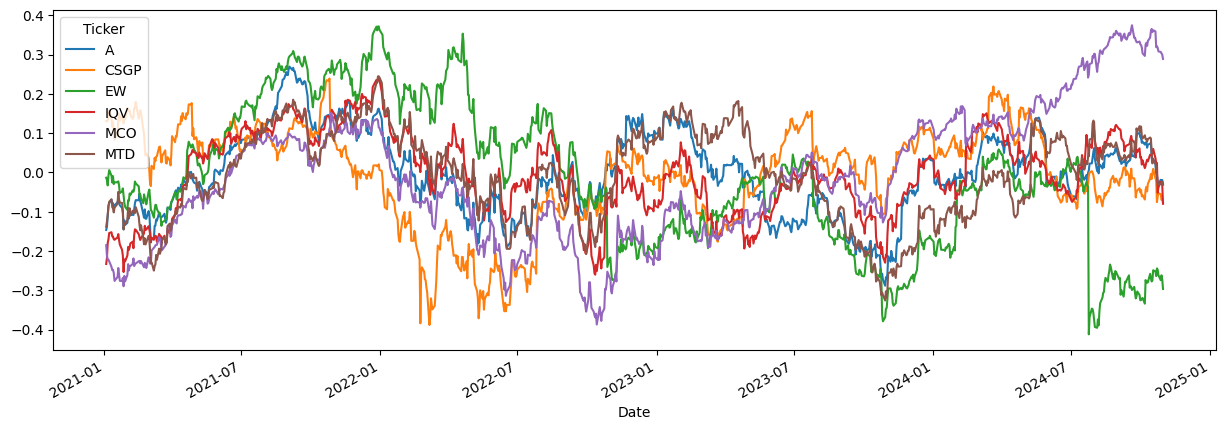

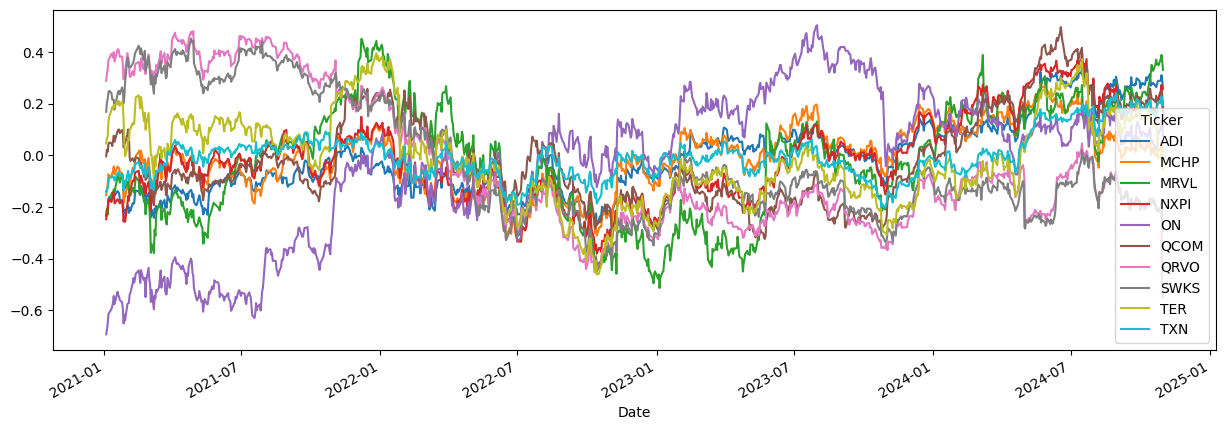

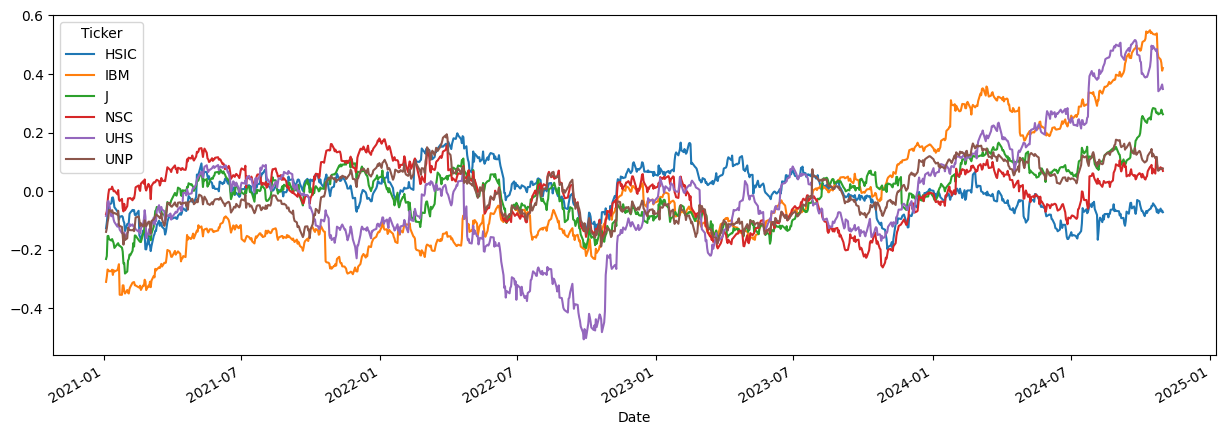

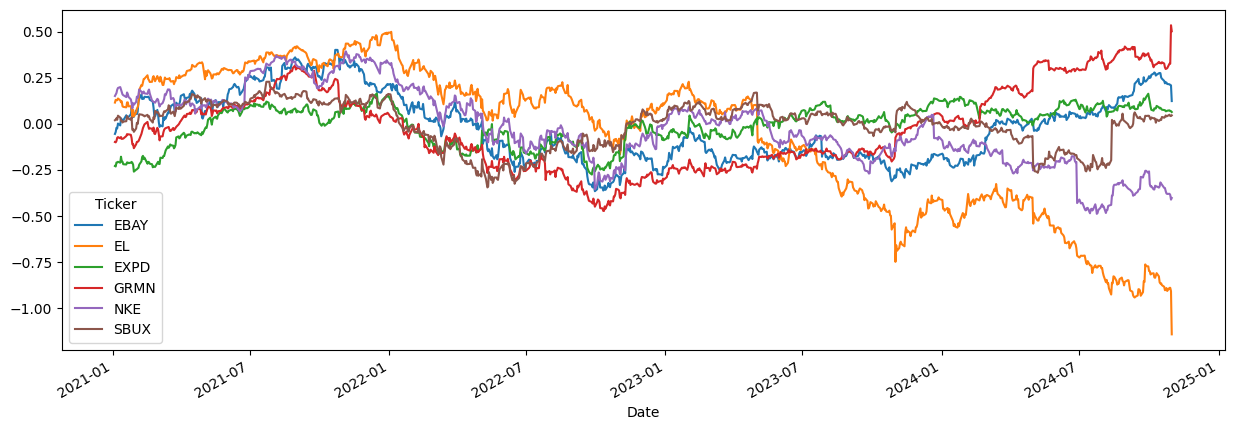

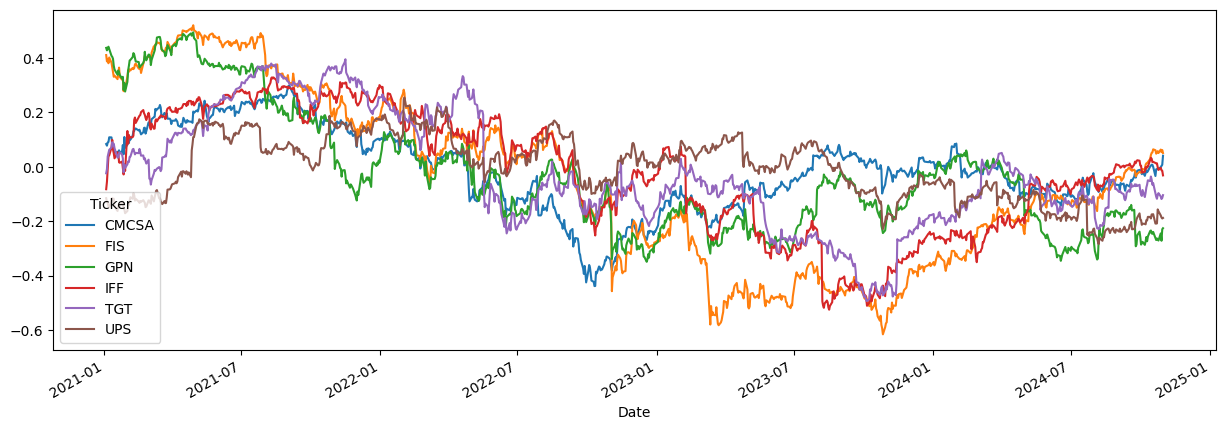

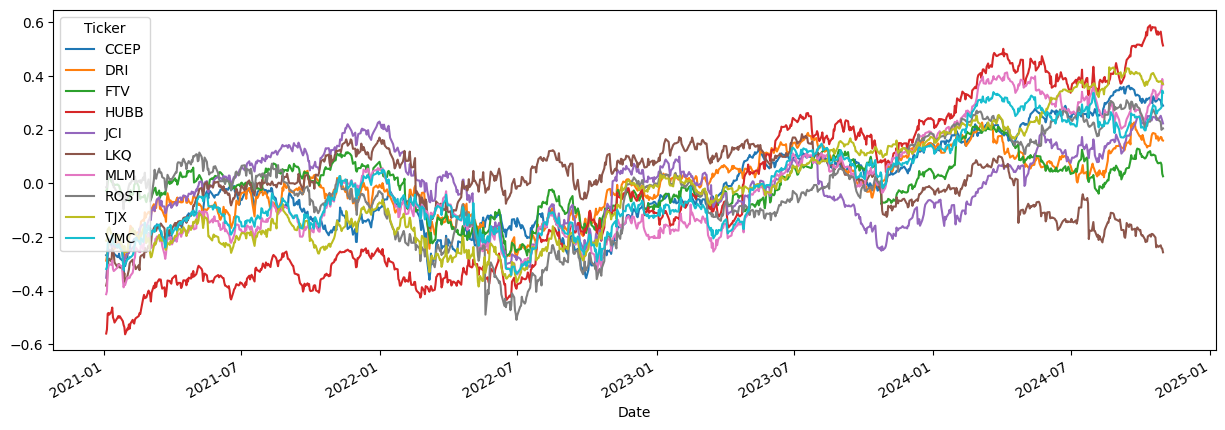

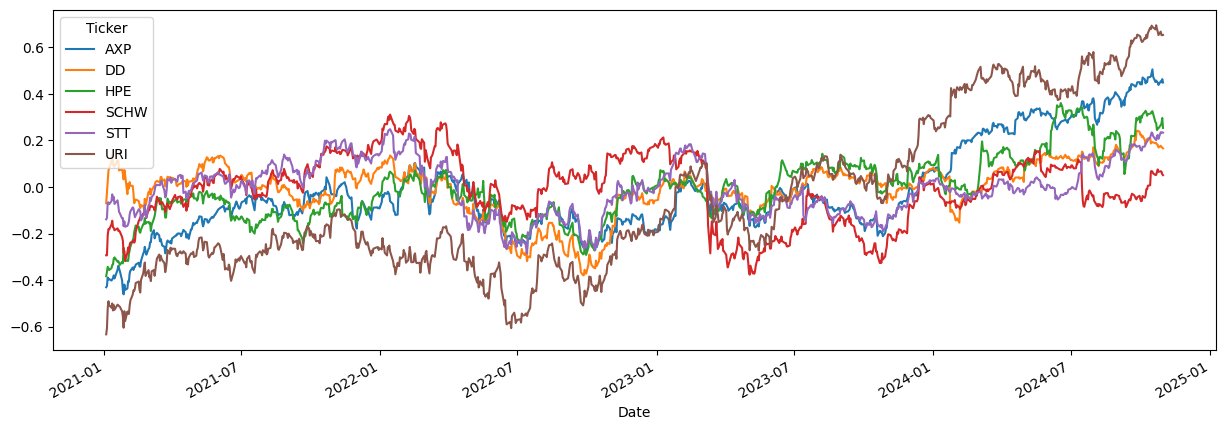

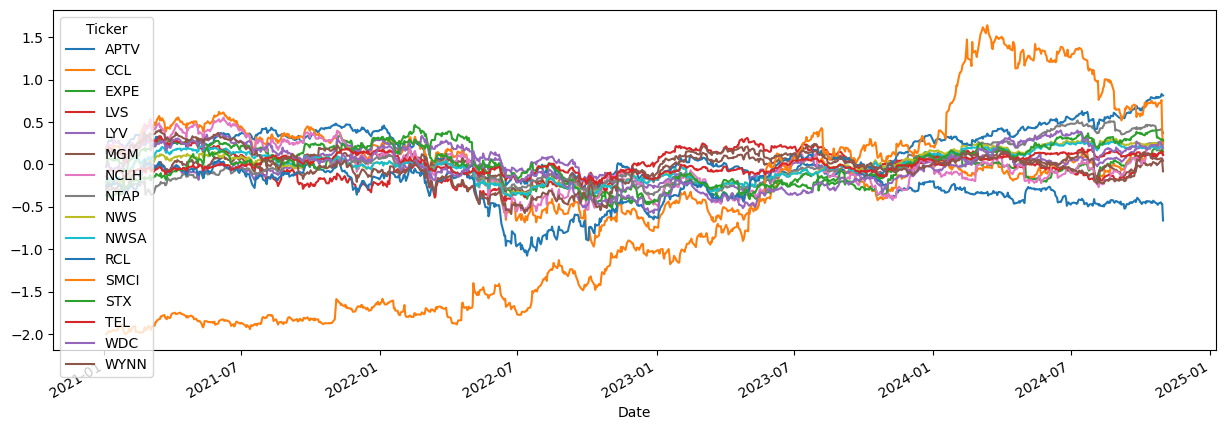

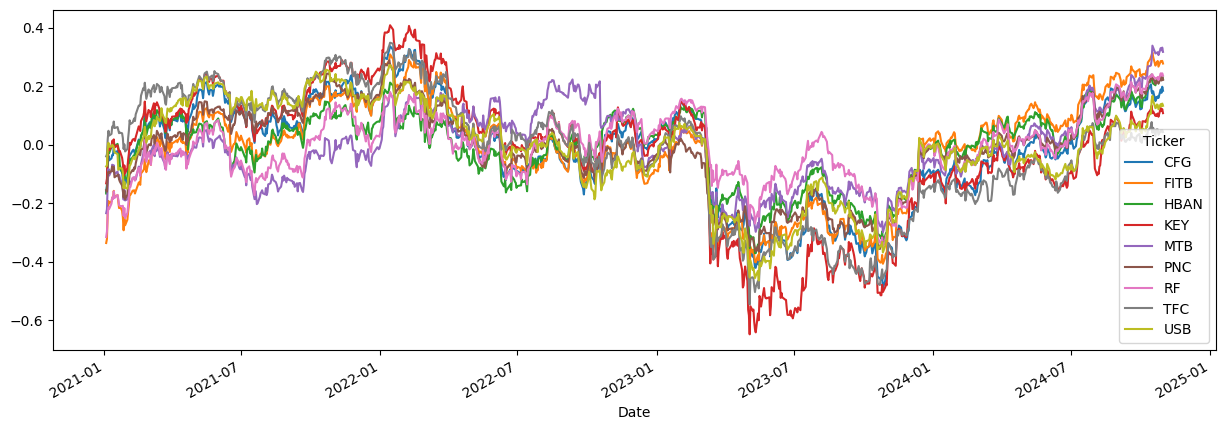

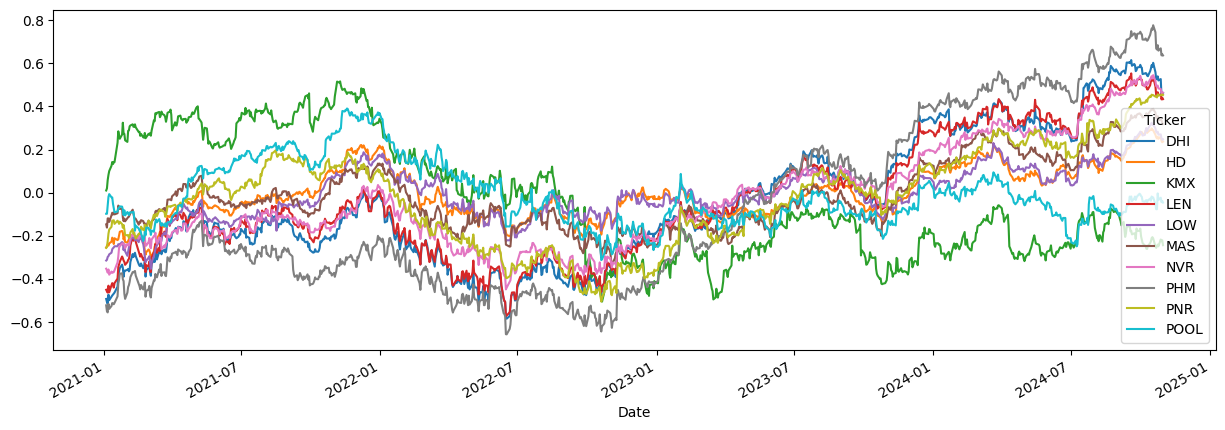

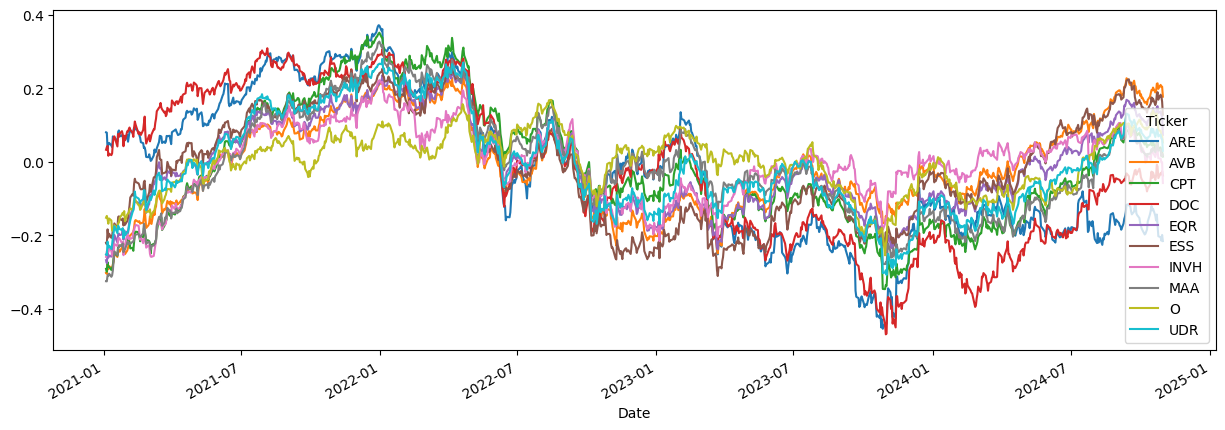

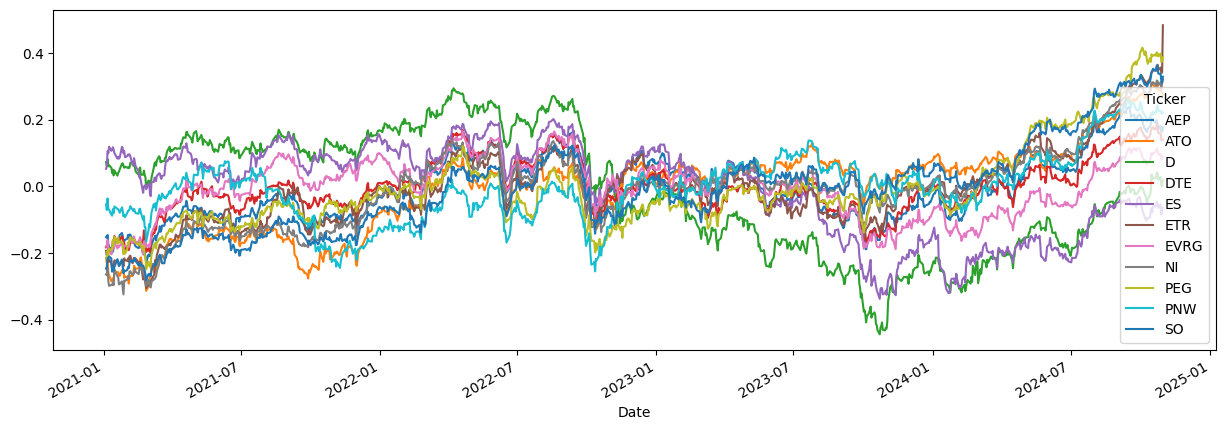

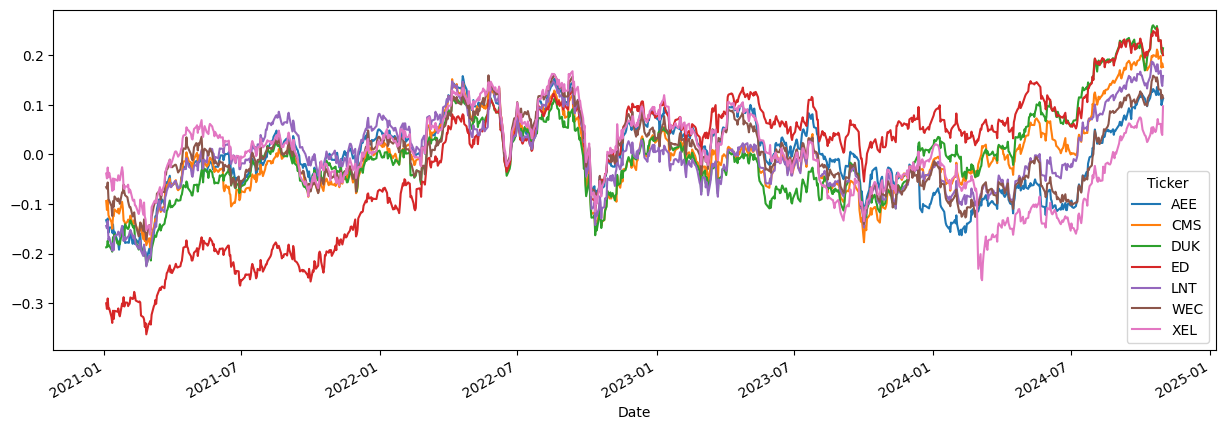

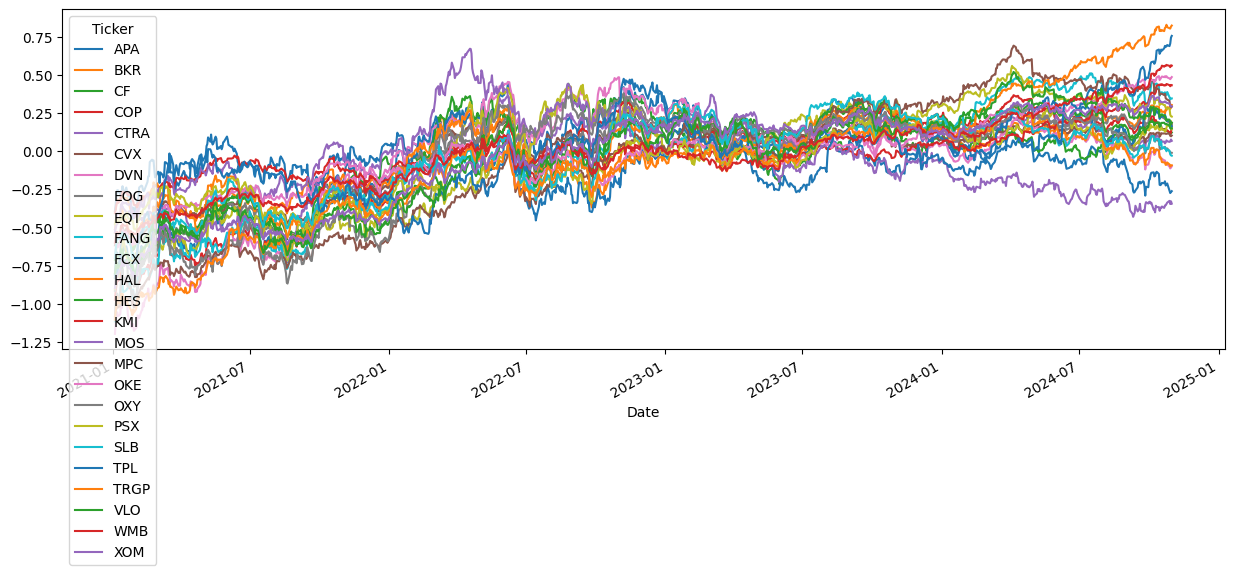

In [28]:
#Stock price trends for each cluster
for clust in range(len(counts)):
  symbols=list(clustered_series[clustered_series==clust].index)
  means=np.log(data_raw[symbols].mean())
  series=np.log(data_raw[symbols]).sub(means)
  series.plot(figsize=(15,5))
  plt.show()

##Pair Filtering
The clustering process resulted in **14 clusters and 787 potential pairs**. In this section, these pairs are filtered using a series of statistical and quantitative tests to identify the most suitable ones for trading.

**Filtering Steps:**
1. **Stationarity Test:** Conducted on the price series of each stock to ensure stationarity, a prerequisite for subsequent cointegration testing.
2. **Cointegration Test:** The core step of pair selection. This test evaluates whether a long-term equilibrium relationship exists between two stocks, effectively reducing the risk of spurious correlations.
3. **Mean-Reversion Test:** The Hurst exponent is used to determine if the spread series exhibits mean-reversion behavior, which is a key requirement for pairs trading.
4. **Half-Life Control:** Measures the speed at which the spread reverts to its mean. Pairs with half-life values that are too short or too long are filtered out to maintain a reasonable trading rhythm.
  * Minimum half-life: **3 periods**
  * Maximum half-life: **150 periods**
5. **Zero-Crossing Count:** Reflects the frequency with which the spread oscillates around its mean. A higher zero-crossing count suggests more frequent mean-reversion opportunities and, consequently, more potential trades.

Each pair is subjected to all the above tests to ensure suitability for trading.

In [ ]:
pip install hurst

In [29]:
from statsmodels.tsa.stattools import coint,adfuller
import statsmodels.api as sm
from hurst import compute_Hc
import collections, functools, operator

In [30]:
#Parameter settings
subsample=0  #Sampling flag
min_half_life=5  #Minimum half-life
max_half_life=150  #Maximum half-life

In [31]:
#Calculate half-life
def calculate_half_life(z_array):
  z_lag=np.roll(z_array,1)
  z_lag[0]=0
  z_ret=z_array-z_lag
  z_ret[0]=0
  z_lag2=sm.add_constant(z_lag)
  model=sm.OLS(z_ret[1:],z_lag2[1:])
  res=model.fit()
  halflife=-np.log(2)/res.params[1]
  return halflife

In [32]:
#Zero-crossing count
def zero_crossings(x):
  x=x-x.mean()
  zero_crossings=sum(1 for i,_ in enumerate(x) if(i+1<len(x)) if ((x[i]*x[i+1]<0)or (x[i]==0)))
  return zero_crossings

In [33]:
#Stationarity test
def check_for_stationarity(X,subsample=0):
  if subsample!=0:
    frequency=round(len(X)/subsample)
    subsampled_X=X[0::frequency]
    result=adfuller(subsampled_X)
  else:
    result=adfuller(X)
  return{'t_statistic':result[0],'p_value':result[1],'critical_values':result[4]}


In [34]:
#Cointegration test, trend test, control half-life
def check_properties(train_series,test_series,p_value_threshold,min_half_life=3,max_half_life=100,min_zero_crossings=0,hurst_threshold=0.5,subsample=0):
  X=train_series[0]
  Y=train_series[1]
  pairs=[(X,Y),(Y,X)]
  pair_stats=[0]*2
  criteria_not_verified='cointegration'
  stats_Y=check_for_stationarity(np.asarray(Y),subsample=subsample)
  if stats_Y['p_value']>0.10:
    stats_X=check_for_stationarity(np.asarray(X),subsample=subsample)
    if stats_X['p_value']>0.10:
      for i,pair in enumerate(pairs):
        S1=np.asarray(pair[0])
        S2=np.asarray(pair[1])
        S1_c=sm.add_constant(S1)
        results=sm.OLS(S2,S1_c).fit()
        b=results.params[1]
        if b>0:
          spread=pair[1]-b*pair[0]
          spread_array=np.asarray(spread)
          stats=check_for_stationarity(spread_array,subsample=subsample)
          if stats['p_value']<p_value_threshold:
            criteria_not_verified='hurst_exponent'
            hurst_exponent,_,_=compute_Hc(spread_array)
            if hurst_exponent<hurst_threshold:
              criteria_not_verified='half_life'
              hl=calculate_half_life(spread_array)
              if (hl>=min_half_life)and (hl<max_half_life):
                criteria_not_verified='mean_cross'
                zero_cross=zero_crossings(spread_array)
                if zero_cross>=min_zero_crossings:
                  criteria_not_verified='None'
                  pair_stats[i]={
                      't_statistic':stats['t_statistic'],
                      'critical_val':stats['critical_values'],
                      'p_value':stats['p_value'],
                      'coint_coef':b,
                      'zero_cross':zero_cross,
                      'half_life':int(round(hl)),
                      'hurst_exponent':hurst_exponent,
                      'spread':spread,
                      'Y_train':pair[1],
                      'X_train':pair[0]
                  }
  if pair_stats[0]==0 and pair_stats[1]==0:
    result=None
  elif pair_stats[0]==0:
    result=1
  elif pair_stats[1]==0:
    result=0
  else:
    if abs(pair_stats[0]['t_statistic'])>abs(pair_stats[1]['t_statistic']):
      result=0
    else:
      result=1
  if result==0:
    result=pair_stats[0]
    result['X_test']=test_series[0]
    result['Y_test']=test_series[1]
  elif result ==1:
    result=pair_stats[1]
    result['X_test']=test_series[1]
    result['Y_test']=test_series[0]
  return result,criteria_not_verified

In [35]:
#Find pairs based on test results
def find_pairs(data_train,data_test,p_value_threshold,min_half_life=3,max_half_life=100,min_zero_crossings=0,hurst_threshold=0.5,subsample=0):
  n=data_train.shape[1]
  keys=data_train.columns
  pairs_fail_criteria={
      'cointegration':0,
      'hurst_exponent':0,
      'half_life':0,
      'mean_cross':0,
      'None':0
  }
  pairs=[]
  for i in range(n):
    for j in range(i+1,n):
      S1_train=data_train[keys[i]]
      S2_train=data_train[keys[j]]
      S1_test=data_test[keys[i]]
      S2_test=data_test[keys[j]]

      result,criteria_not_verified=check_properties((S1_train,S2_train),(S1_test,S2_test),p_value_threshold,min_half_life,max_half_life,min_zero_crossings,hurst_threshold,subsample)
      pairs_fail_criteria[criteria_not_verified]+=1
      if result is not None:
        pairs.append((keys[i],keys[j],result))
  return pairs,pairs_fail_criteria





In [36]:
def get_candidate_pairs(clustered_series,pricing_df_train,pricing_df_test,min_half_life=3,max_half_life=100,min_zero_crosings=20,p_value_threshold=0.05,hurst_threshold=0.5,subsample=0):
  total_pairs,total_pairs_fail_criteria=[],[]
  n_clusters=len(clustered_series.value_counts())
  for clust in range(n_clusters):
    sys.stdout.write(f'\rCluster{clust+1}/{n_clusters}')
    sys.stdout.flush()
    symbols=list(clustered_series[clustered_series==clust].index)
    cluster_pricing_train=pricing_df_train[symbols]
    cluster_pricing_test=pricing_df_test[symbols]
    pairs,pairs_fail_criteria=find_pairs(cluster_pricing_train,cluster_pricing_test,p_value_threshold,min_half_life,max_half_life,min_zero_crosings,hurst_threshold,subsample)
    total_pairs.extend(pairs)
    total_pairs_fail_criteria.append(pairs_fail_criteria)
  print(f'Found {len(total_pairs)} pairs')
  unique_tickers=np.unique([(element[0],element[1]) for element in total_pairs])
  print(f'The pairs contain {len(unique_tickers)} tickers')
  review=dict(functools.reduce(operator.add,map(collections.Counter,total_pairs_fail_criteria)))
  print('Pairs Selection failed stage:',review)
  return total_pairs,unique_tickers






###Pair Selection Results
After filtering, **132 pairs** were selected from the initial **787 potential pairs**, involving a total of **91 stocks**.

* 641 pairs failed the cointegration test.
* 15 pairs did not exhibit mean-reversion characteristics within the selected time frame.
* 130 pairs showed no zero-crossing behavior in their spread series.

In [37]:
#Pairing results
pairs_unsupervised,unique_tickers=get_candidate_pairs(clustered_series=clustered_series,pricing_df_train=df_prices_train,pricing_df_test=df_prices_test,min_half_life=min_half_life,max_half_life=max_half_life,min_zero_crosings=12,p_value_threshold=0.1,hurst_threshold=0.5,subsample=subsample)

Cluster14/14Found 132 pairs
The pairs contain 91 tickers
Pairs Selection failed stage: {'cointegration': 641, 'None': 130, 'hurst_exponent': 15, 'mean_cross': 1}


In [ ]:
"""
#Visualize spread (a bit messy)
for i in range(len(pairs_unsupervised)):
    pairs_unsupervised[i][2]['spread'].plot()
"""

In [ ]:
#Zero-crossing count for each pair
for i in range(len(pairs_unsupervised)):
    print(pairs_unsupervised[i][2]['zero_cross'])

In [39]:
#Create a new industry index
new_ticker=ticker.copy()
new_ticker.set_index('Ticker',inplace=True)

In [40]:
#Symbol of each pair and its corresponding industry
count_different_category = 0
for pair in pairs_unsupervised:
    print('------------------------------------------------')
    print('Leg 1: {}. Segment: {}. Category: {}'.format(pair[0], new_ticker.loc[pair[0]]['GICS Sector'],new_ticker.loc[pair[0]]['GICS Sector']))
    print('Leg 2: {}. Segment: {}. Category: {}'.format(pair[1], new_ticker.loc[pair[1]]['GICS Sector'],new_ticker.loc[pair[1]]['GICS Sector']))
    if new_ticker.loc[pair[0]]['GICS Sector'] != new_ticker.loc[pair[1]]['GICS Sector']:
        count_different_category += 1
print(f'There are {len(pairs_unsupervised)} pairs in total')
print(f'Among them,  {count_different_category} pairs come from different industries')

------------------------------------------------
Leg 1: A. Segment: Health Care. Category: Health Care
Leg 2: EW. Segment: Health Care. Category: Health Care
------------------------------------------------
Leg 1: ADI. Segment: Information Technology. Category: Information Technology
Leg 2: MCHP. Segment: Information Technology. Category: Information Technology
------------------------------------------------
Leg 1: MCHP. Segment: Information Technology. Category: Information Technology
Leg 2: NXPI. Segment: Information Technology. Category: Information Technology
------------------------------------------------
Leg 1: MCHP. Segment: Information Technology. Category: Information Technology
Leg 2: QCOM. Segment: Information Technology. Category: Information Technology
------------------------------------------------
Leg 1: MRVL. Segment: Information Technology. Category: Information Technology
Leg 2: QCOM. Segment: Information Technology. Category: Information Technology
---------------

##Signal Determination and Backtesting
A **standard deviation-based trading strategy** is employed to generate buy, sell, and close signals:

|Parameters|Values|
|:-:|:-:|
|Buy|μ-2σ|
|Sell|μ+2σ|
|Close|μ|

Trading actions are triggered when the spread, adjusted for cointegration, deviates from its mean by **two standard deviations**. Positions are closed when the spread reverts to the mean.

**Trading Settings:**
* **Transaction Costs:**
  * Initial Capital: **$10,000**
  * Commission Rate: **0.00025**
  * Slippage: **0.001**
* **Trading Delays:** Trades are executed on the second trading day after a signal is generated to account for execution delays.
* **Initial Period Exclusion:** The first **5 trading days** in the selected time frame are excluded from trading to prevent biases due to insufficient data.
* **Position Management:** ORDER_PCT is set to 1, meaning the entire portfolio is allocated to each trade.




In [41]:
#Signal determination
def threshold_strategy(y,x,beta,entry_level=1.0,exit_level=1.0,stabilizing_threshold=5,ORDER_PCT1=1,ORDER_PCT2=1):
  spread=y-beta*x
  norm_spread=(spread-spread.mean())/np.std(spread)
  norm_spread=np.asarray(norm_spread.values)

  longs_entry=norm_spread<-entry_level
  longs_exit=norm_spread>-exit_level
  shorts_entry=norm_spread>entry_level
  shorts_exit=norm_spread<exit_level

  num_units_long=pd.Series(np.nan,index=y.index)
  num_units_short=pd.Series(np.nan,index=y.index)

  longs_entry[:stabilizing_threshold]=False
  longs_exit[:stabilizing_threshold]=False
  shorts_entry[:stabilizing_threshold]=False
  shorts_exit[:stabilizing_threshold]=False

  num_units_long[longs_entry]=1
  num_units_long[longs_exit]=0
  num_units_short[shorts_entry]=-1
  num_units_short[shorts_exit]=0

  #Position size
  symbol_cols=pd.Index(['y','x'],name='symbol')
  order_size=pd.DataFrame(index=y.index,columns=symbol_cols)
  order_size['y']=np.nan
  order_size['x']=np.nan
  order_size.loc[num_units_short==-1,'y']=-ORDER_PCT1
  order_size.loc[num_units_short==0,'y']=ORDER_PCT1
  order_size.loc[num_units_long==1,'y']=ORDER_PCT1
  order_size.loc[num_units_long==0,'y']=-ORDER_PCT1
  order_size.loc[num_units_short==-1,'x']=ORDER_PCT2
  order_size.loc[num_units_short==0,'x']=-ORDER_PCT2
  order_size.loc[num_units_long==1,'x']=-ORDER_PCT2
  order_size.loc[num_units_long==0,'x']=ORDER_PCT2
  #Execute orders on the next trading day
  order_size=order_size.shift(1)
  return order_size

In [42]:
#Backtest
def apply_trading_strategy(pairs,strategy='fixed_beta',entry_multiplier=2,exit_multiplier=0,test_mode=False,train_val_split='2024-04-10'):
  results={}
  portfolios={}

  for i,pair in enumerate(pairs):
    sys.stdout.write('\r'+f'Pair{i+1}/{len(pairs)}')
    sys.stdout.flush()
    pair_info=pair[2]
    if test_mode:
      y=pair_info['Y_test']
      x=pair_info['X_test']
    else:
      y=pair_info['Y_train']
      x=pair_info['X_train']
    if strategy=='fixed_beta':
      close_pair_price=pd.concat((pair_info['Y_train'],pair_info['X_train']),axis=1,keys=['y','x'])




      order_size=threshold_strategy(pair_info['Y_train'],pair_info['X_train'],pair_info['coint_coef'],entry_level=entry_multiplier,exit_level=exit_multiplier,stabilizing_threshold=5,ORDER_PCT1=1,ORDER_PCT2=1)


      pf=vbt.Portfolio.from_orders(close_pair_price,
                                   size=order_size,
                                   val_price=close_pair_price.vbt.fshift(1),
                                   init_cash=10000,
                                   fees=0.00025,
                                   slippage=0.001,
                                   cash_sharing=True,
                                   group_by=True,
                                   call_seq='auto',
                                   freq='d'

                                   )
      results[pair[0]+'_'+pair[1]]=pf.stats()
      portfolios[pair[0]+'_'+pair[1]]=pf
  return results,portfolios




In [43]:
results,portfolios=apply_trading_strategy(pairs_unsupervised,)

Pair132/132

##Backtesting Results
The **132 selected pairs** were backtested, and the pair with the **highest total return** was chosen for detailed analysis.

In [44]:
pd_results=pd.DataFrame.from_dict(results,orient='index')

In [45]:
pd_results['Sharpe Ratio'].mean()

0.7702868984311896

The backtesting results of all pairs were sorted in descending order based on **Total Return**.

In [46]:
pd_results.sort_values('Total Return [%]',ascending=False)

Start        End   Period  Start Value      End Value  \
KMX_POOL  2021-01-04 2024-06-13 867 days      10000.0   38199.123960   
DRI_HUBB  2021-01-04 2024-06-13 867 days      10000.0   28209.155706   
EL_NKE    2021-01-04 2024-06-13 867 days      10000.0   26361.618382   
FIS_TGT   2021-01-04 2024-06-13 867 days      10000.0   25426.919324   
NXPI_QCOM 2021-01-04 2024-06-13 867 days      10000.0   23874.986780   
...              ...        ...      ...          ...            ...   
FTV_MLM   2021-01-04 2024-06-13 867 days      10000.0  -10912.857816   
DD_URI    2021-01-04 2024-06-13 867 days      10000.0  -12789.278875   
NVR_PHM   2021-01-04 2024-06-13 867 days      10000.0  -26372.118283   
DHI_NVR   2021-01-04 2024-06-13 867 days      10000.0 -165075.503126   
LEN_NVR   2021-01-04 2024-06-13 867 days      10000.0 -220950.001680   

           Total Return [%]  Benchmark Return [%]  Max Gross Exposure [%]  \
KMX_POOL         281.991240            -12.553714             2034.564756   
DRI_HUBB         182.091557            102.256352             6512.128576   
EL_NKE           163.616184            -41.733159            29662.813840   
FIS_TGT          154.269193            -26.020269             3488.500431   
NXPI_QCOM        138.749868             69.294682             2594.009222   
...                     ...                   ...                     ...   
FTV_MLM         -209.128578             58.342708            11610.302417   
DD_URI          -227.892789            100.100138             6623.643921   
NVR_PHM         -363.721183            136.522542            35399.342199   
DHI_NVR        -1750.755031            104.945903             3158.042975   
LEN_NVR        -2309.500017            104.369201             1580.195242   

           Total Fees Paid  Max Drawdown [%]  ... Avg Winning Trade [%]  \
KMX_POOL         99.735687         18.455549  ...             16.191228   
DRI_HUBB         77.552059         32.181531  ...             11.149823   
EL_NKE           72.775663         47.628622  ...             22.901667   
FIS_TGT          54.322757         32.770102  ...             16.713932   
NXPI_QCOM        69.154272         22.000871  ...             18.209085   
...                    ...               ...  ...                   ...   
FTV_MLM          83.130044        193.065695  ...              9.775449   
DD_URI           88.335318        240.704147  ...             12.626759   
NVR_PHM        1071.565990        320.083242  ...             11.638182   
DHI_NVR        1138.984855        388.528150  ...             16.333629   
LEN_NVR        1024.575904        262.150669  ...             12.274483   

           Avg Losing Trade [%]  Avg Winning Trade Duration  \
KMX_POOL             -10.055733 165 days 03:53:01.742738588   
DRI_HUBB              -5.710238           192 days 16:30:00   
EL_NKE               -10.148375 218 days 14:46:35.294117648   
FIS_TGT               -4.008193 189 days 09:48:21.492537312   
NXPI_QCOM            -17.504134 280 days 03:58:30.835913312   
...                         ...                         ...   
FTV_MLM              -18.476958 472 days 15:22:54.545454544   
DD_URI               -21.232381 447 days 09:05:18.367346944   
NVR_PHM              -17.155421 193 days 16:24:15.319148936   
DHI_NVR              -12.814133 333 days 02:38:07.850467288   
LEN_NVR              -15.542140 164 days 12:41:34.832826748   

            Avg Losing Trade Duration  Profit Factor  Expectancy  \
KMX_POOL  180 days 01:31:43.184713376       9.454899   32.388098   
DRI_HUBB  135 days 22:03:52.258064516       6.481494   13.946471   
EL_NKE    229 days 07:06:18.947368424       2.659317   16.550524   
FIS_TGT   188 days 12:16:21.818181818      29.647482   18.710549   
NXPI_QCOM 361 days 22:21:28.421052628       4.113118   16.257810   
...                               ...            ...         ...   
FTV_MLM             344 days 06:54:00       0.271972  -17.796418   
DD_URI    323 days 07:3

The pair with the highest return is **“KMX”** and **“POOL”**. Below is a detailed analysis of the backtesting results for this pair.

* In this backtest, the **Max Gross Exposure [%]** appears exceptionally high due to **a calculation issue in the vectorbt library’s backtesting methodology for pairs trading.** It incorrectly sums the relative position sizes of all trades, treating the positions of both stocks as gross exposure when they are open simultaneously, instead of calculating the net exposure.

In [47]:
print(f"The pair with the highest return rate is:{pd_results['Total Return [%]'].idxmax()}")
pd_results.loc[pd_results['Total Return [%]'].idxmax()]

The pair with the highest return rate is:KMX_POOL


Start                                 2021-01-04 00:00:00
End                                   2024-06-13 00:00:00
Period                                  867 days 00:00:00
Start Value                                       10000.0
End Value                                     38199.12396
Total Return [%]                                281.99124
Benchmark Return [%]                           -12.553714
Max Gross Exposure [%]                        2034.564756
Total Fees Paid                                 99.735687
Max Drawdown [%]                                18.455549
Max Drawdown Duration                   144 days 00:00:00
Total Trades                                          798
Total Closed Trades                                   796
Total Open Trades                                       2
Open Trade PnL                                2418.197857
Win Rate [%]                                    60.552764
Best Trade [%]                                  37.877091
Worst Trade [%]                                -40.146308
Avg Winning Trade [%]                           16.191228
Avg Losing Trade [%]                           -10.055733
Avg Winning Trade Duration    165 days 03:53:01.742738588
Avg Losing Trade Duration     180 days 01:31:43.184713376
Profit Factor                                    9.454899
Expectancy                                      32.388098
Sharpe Ratio                                      1.81225
Calmar Ratio                                     4.107624
Omega Ratio                                      1.393228
Sortino Ratio                                    3.110854
Name: KMX_POOL, dtype: object

In [48]:
#Order details
portfolios['KMX_POOL'].orders.records_readable

Order Id  Column  Timestamp  Size       Price      Fees  Side
0            0  (x, x) 2021-01-12   1.0  106.393500  0.026598  Sell
1            1  (y, y) 2021-01-12   1.0  370.744031  0.092686   Buy
2            2  (x, x) 2021-01-13   1.0  105.384508  0.026346  Sell
3            3  (y, y) 2021-01-13   1.0  359.881770  0.089970   Buy
4            4  (x, x) 2021-01-14   1.0  106.243648  0.026561  Sell
...        ...     ...        ...   ...         ...       ...   ...
1717      1717  (x, x) 2024-06-11   1.0   68.948877  0.017237   Buy
1718      1718  (x, x) 2024-06-12   1.0   70.029898  0.017507  Sell
1719      1719  (y, y) 2024-06-12   1.0  345.866151  0.086467   Buy
1720      1720  (y, y) 2024-06-13   1.0  341.461846  0.085365  Sell
1721      1721  (x, x) 2024-06-13   1.0   70.360291  0.017590   Buy

[1722 rows x 7 columns]

###Charts Section
To ensure price continuity, **all non-trading time points (e.g., weekends, holidays) were removed.**

<Axes: title={'center': 'KMX_POOL Price'}, xlabel='Date'>

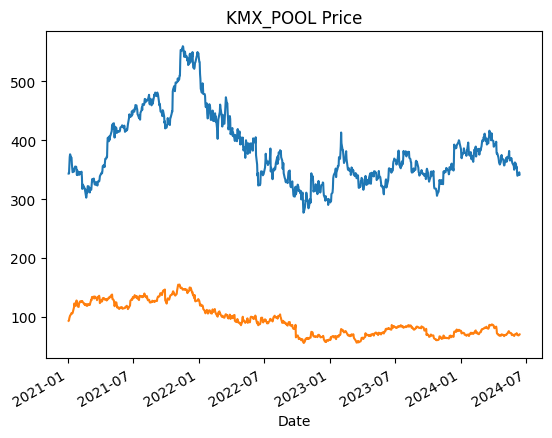

In [49]:
#Price trends of the two stocks
portfolios['KMX_POOL'].close.plot(title='KMX_POOL Price',legend=False)

The chart below displays the cumulative returns of the strategy:
* The **purple line** represents the **cumulative returns** of the trading strategy.
* The **dark green line** represents the **benchmark return**, calculated as the buy-and-hold return from the start to the end of the trading period.

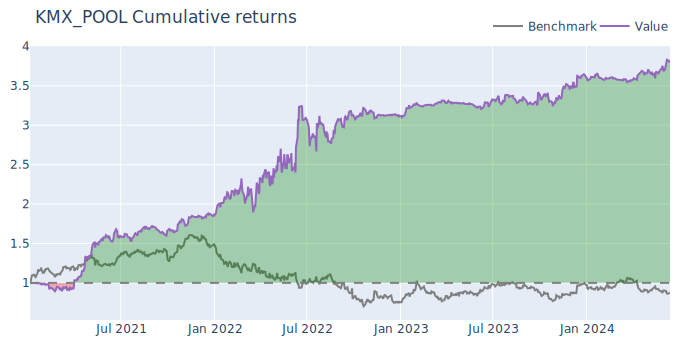

In [50]:
portfolios['KMX_POOL'].plot_cum_returns(title='KMX_POOL Cumulative returns').show_svg()

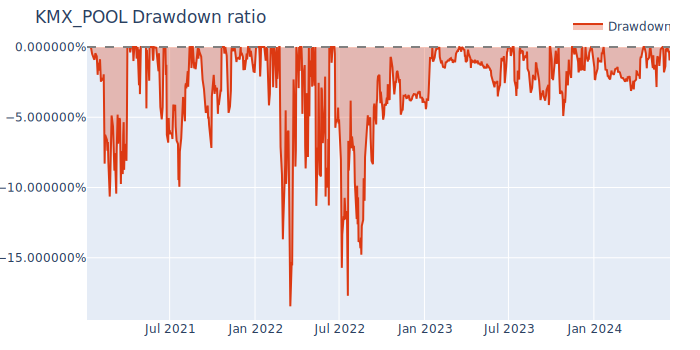

In [51]:
portfolios['KMX_POOL'].plot_underwater(title='KMX_POOL Drawdown ratio').show_svg()

In [52]:
from functools import partial

In [53]:
def plot_orders(portfolio,column=None,add_trace_kwargs=None,fig=None):
  portfolio.orders.plot(column=column,add_trace_kwargs=add_trace_kwargs,fig=fig)

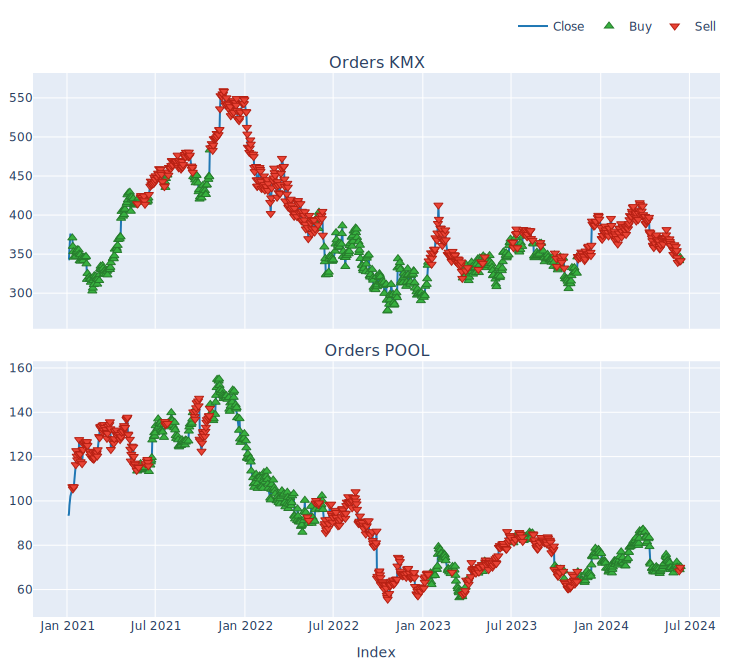

In [54]:
def plot_orders(portfolio,column=None,add_trace_kwargs=None,fig=None):
  portfolio.orders.plot(column=column,add_trace_kwargs=add_trace_kwargs,fig=fig)
portfolios['KMX_POOL'].plot(subplots=[
    ('KMX_orders',dict(
        title='Orders KMX',
        yaxis='Price',
        check_is_not_grouped=False,
        plot_func=partial(plot_orders,column=('y','y')),
        pass_column=False
    )),
     ('POOL_orders', dict(
        title='Orders POOL',
        yaxis='Price',
        check_is_not_grouped=False,
        plot_func=partial(plot_orders, column=('x','x')),
        pass_column=False
    )),
]).show_svg()

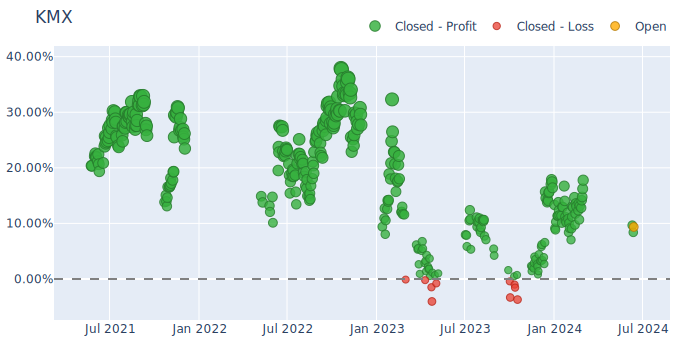

In [55]:
portfolios['KMX_POOL'].trades.plot_pnl(column=('y','y'),title='KMX').show_svg()

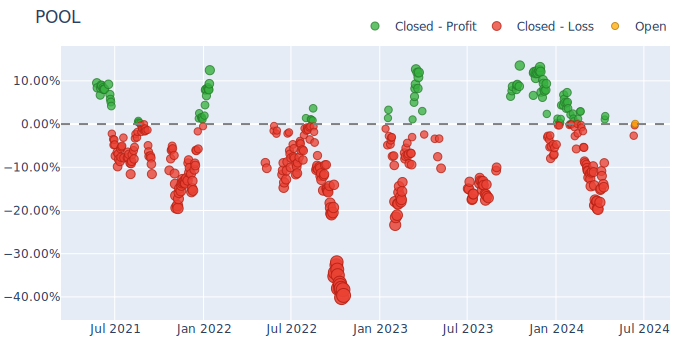

In [56]:
portfolios['KMX_POOL'].trades.plot_pnl(column=('x','x'),title='POOL').show_svg()

#Summary
This notebook demonstrates the effectiveness and practicality of the pairs trading strategy applied to historical data from the S&P 500 and Nasdaq 100 stocks.

* During the 867-day backtest period, the total return was 281.99%, significantly outperforming the benchmark return of -12.55%, showcasing the strong profitability of this strategy.
* The **Sharpe Ratio** was 1.81,**Calmar Ratio** was 4.11 indicating excellent risk-adjusted performance.
* The **Max Drawdown** was 18.45% indicating good risk control.
* A total of **798 trades** were executed, with **796 closed**, resulting in a win rate of 60.55%.

**While the pairs trading process is effective, there are still many areas for improvement:**
* **Data:**
  * Using data with different time intervals, such as 60-minute or 120-minute intervals, could help capture trading opportunities more effectively.
  * Literature suggests that the length of the training data period influences the results, so extending the time window could be beneficial.
  * It may also be worth exploring related ETFs, as ETFs tend to be more stable compared to individual stocks.
* Both machine learning models and statistical analysis involve many parameters. Using techniques like grid search or Bayesian optimization to fine-tune parameters could improve results.
* The strategy currently uses a basic standard deviation approach. More advanced time series models, such as ARIMA or LSTM, could be applied to predict the spread and better manage the mean deviation. (For example, using LSTM models to predict the spread and trigger trading signals can help control drawdowns, but might sacrifice some profits.)
* Some trades had long holding durations, which negatively impacted overall performance. In the future, improving the exit strategy or employing time-based stop-loss strategies (such as Alpha decay models or event-driven stop-loss) could help.
* By incorporating momentum factors, we can reduce position size when market momentum is strong. Dynamic position sizing and enhanced risk control models, such as volatility control and stop-loss strategies, could also help manage drawdowns.
* More refined cointegration monitoring could be applied. For example, adding dynamics by setting a sliding window to periodically reassess cointegration relationships and exit positions when the relationship fails. Alternatively, more complex cointegration tests, such as Copula, could be used.